# Homework 3

Write your own Metropolis Hastings (and Gibbs) sampler. Feel free to use some of the code above:
* Choose a bivariate normal (Gaussian) distribution as the likelihood of the 2-dimensional data vector $p(D|\theta_1, \theta_2)$

$$p(D|\theta_1, \theta_2) \propto \exp \biggl( -\frac{1}{2} \underbrace{\left[ (D-M)^t \, C^{-1} \, (D-M) \right]}_{\chi^2(\theta_1, \theta_2)}  \biggr) $$
* Assume $\theta_1$ ranges from 0.1-0.5, and $\theta_2$ ranges from 0.6-1.0. The true values are $\theta_1=0.3$ and $\theta_2=0.8$
* Assume a simple mapping of the underlying parameters $\theta_1$, $\theta_2$ onto the data vector $D=(d_1,d_2)$, e.g. the simplest mapping is $d_1=\theta_1$ and $d_2=\theta_2$. Please use something slightly more complex. Note that usually the mapping of underlying parameters onto data is a complex function involving ODEs, PDEs, intergrals, interpolation routines, differentiation, etc. More importantly, each data point is usually a function of several, sometimes of all underlying parameters; there is not a 1-1 mapping of a parameter onto 1 data point (although there are transformations on the data vector that can achieve this).
* Define a conjugate, uninfromative prior (uninformative under the assumption that parameters enter linearly). Later choose more informative priors.
* Define a (co)variance matrix in data space, and play with the values of $N$ and $\rho$ (you can set both to zero at first)
$$
\begin{bmatrix}
d_1^2+N & \rho\\
\rho & d_2^2+N
\end{bmatrix}
$$

* With all this information, generate a data vector $D$ at the true values $\theta_1$ and $\theta_2$ and then sample $\theta_1$ and $\theta_2$ (using your model definition and your covariance matrix) based on a Metropolis Hastings (and Gibbs) to estimate the posterior probability.

* Repeat the above with different priors, different values for $N$ and $\rho$ in the covariance, explain what you see. Feel free to go to higher dimensions in both data and parameter space.

# Monte Carlo Sampling

In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import scipy.stats as st
import corner
# BP Necessary imports.

First we create some model that links our data space and parameter space. For the sake of this example this is a fabricated relation, however this is typically where all of the physics and astrophysics is stored. This could be a stellar model that takes in mass, gravity, and metallicity and provides an SED, or a model that gives protoplanetary mass from disk parameters.

In [2]:
def model(thetas):
    '''
    Mapping of underlying parameters onto data vector.
    '''
    d_1 = thetas[0] - thetas[1]**2
    d_2 = np.log(thetas[1])
    # BP Defining arbitrary non-linear model.
    
    return np.array([d_1, d_2])

Now we create our priors. This contains all previous knowledge on the values of the parameters. For our initial run, we assume no prior knowledge and adopt a uniform prior on a set interval for each parameter. These limits could have some physical motivation.

In [3]:
def uniform_prior(thetas):
    '''
    Prior distribution defining propability of parameters being a given value.
    '''
    if (thetas[0] < 0.1) | (thetas[0] > 0.5):
        return 0
    elif (thetas[1] < 0.6) | (thetas[1] > 1.0):
        return 0
    else:
        return 1
    # BP Defining uninformative (uniform) priors from 0.1-0.5 and 0.6-1.0.

Typically, the most difficult part of Bayesian analysis is defining our likelihood. This describes how likely it is that our given model, typically supplied by the sampler, would result in the data values seen. We choose to calculate this as a multivariate Gaussian, although there are many choices for this function.

In [4]:
def likelihood(thetas, data, covariance):
    '''
    Probability that given values for parameters in the model would produce observed data.
    Defined using a bivariate Gaussian.
    '''
    chi_sq = np.transpose(data - model(thetas)) @ np.linalg.inv(covariance) @ (data - model(thetas))
    # BP Calculating chi squared function in power of exponential.
    L = np.exp(-0.5 * chi_sq)
    # BP Evaluating full likelihood.
    
    return L

## Metropolis-Hastings

We now lay out the Metropolis-Hastings sampling method. The basics of the algorithm is as follows:

1. Select some starting point $p$ sampled from the prior distribution.
2. Calculate the target distribution at this point, which is $likelihood \times prior$.
3. Choose a new proposed value $p'$ such that $p' = p + \Delta p$ where $\Delta p$ is sampled from a proposal distribution. We choose for this to be a Gaussian with mean 0.
4. Calculate the target distribution at this new proposed point.
5. Calculate the ratio of the target distributions $\rho$.
6. Accept the new proposed point if $\rho > 1$.
7. Otherwise, draw from a uniform distribution on $[0,1)$ and accept the point if $rho > u$, otherwise reject the point.
8. After repeating for $k$ steps, the target distribution will approach a scaled version of the true posterior.

In [5]:
def mcmc_mh(n, theta0, sigma, target_fn):
    '''
    Primary loop to calculate posterior (target) distribution for a given prior and likelihood using the Metropolis-Hastings MCMC algorithm.
    '''
    samples = np.empty([n, np.size(theta0)])
    n_accept = 0
    thetas = theta0
    # BP Looping over all iterations
    for i in range(n):
        target = target_fn(thetas)
        # BP Calculating target distribution for current point.
        
        thetas_prime = thetas + rand.normal(0, sigma, size = 2)
        # BP Calculating new point as small perturbation from current point by sampling a Gaussian with width sigma and mean zero.
        target_prime = target_fn(thetas_prime)
        # BP Calculating target distribution for new point.
        
        rho = target_prime / target
        # BP Calculating likelihood ratio of new point to old point.
        
        u = rand.uniform()
        # BP Sampling from random distribution.
        
        # BP Checking if ratio is less than the random uniform sample, which is only true when the ratio is less than 1.
        if u < rho:
            n_accept += 1
            thetas = thetas_prime
            # BP Accepting new point as a point in the chain if it is better than the current point (rho > 1) or if it is randomly selected (rho > u).
        else:
            pass
            # BP Rejecting point if it is not selected (rho < u).
        samples[i] = thetas
        # BP Setting next point in the chain.
        
    print("Finished {} steps with an efficiency of {:.2f}%".format(n, n_accept/n*100))
    
    return samples

We now define the specifics of our problem, including the data, covariance matrix, number of steps, step size, and starting point.

In [6]:
data = model([0.3, 0.8])
# BP Defining data from model based on exact parameters.

N = 0.001
# BP Defining noise.
p = 0
# BP Defining off-axis covariance elements.

covariance = np.array([[data[0]**2 + N, p],
                       [p, data[1]**2 + N]])
# BP Defining covariance matrix.

n = 100
# BP Defining number of steps.
sigma = 0.1
# BP Defining width of proposal distribution.
theta0 = [0.2, 0.9]
# BP Defining starting parameters.

def target(thetas):
    '''
    Target distribution as a function of purely parameters. Uses already defined prior, likelihood, data, and covariance.
    '''
    return uniform_prior(thetas) * likelihood(thetas, data, covariance)
# BP Defining target distribution using already specified variables.

All that is left is to now run the MH Sampler and plot the results.

Finished 100 steps with an efficiency of 68.00%


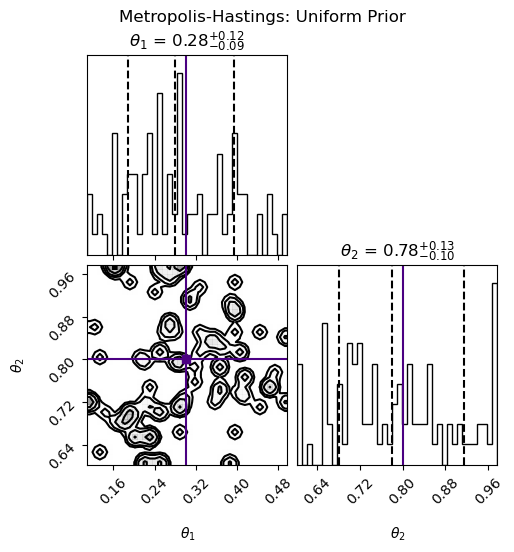

In [7]:
samples = mcmc_mh(n, theta0, sigma, target)
# BP Running the MCMC.
figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 40,
    truth_color = 'indigo',
    )
_ = figure.suptitle('Metropolis-Hastings: Uniform Prior', y = 1.01)

We clearly have not sampled enough of the parameter space. Let us increase the number of steps.

Finished 100000 steps with an efficiency of 58.88%


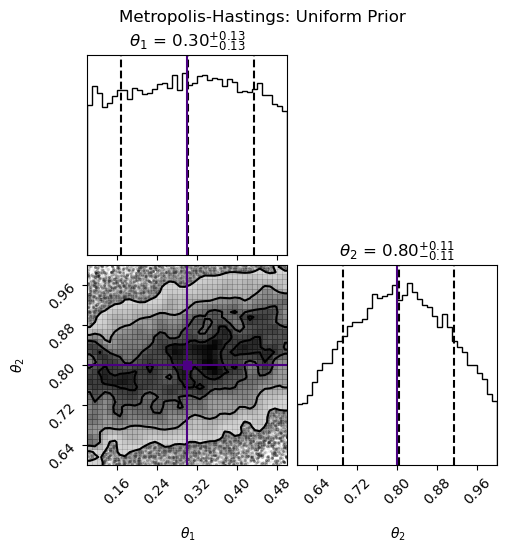

In [8]:
n = 100000
# BP Defining the number of steps.
samples = mcmc_mh(n, theta0, sigma, target)
# BP Running the MCMC.

figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 40,
    truth_color = 'indigo',
    )
_ = figure.suptitle('Metropolis-Hastings: Uniform Prior', y = 1.01)

This looks much better. From this result, we can tell that the parameters are fairly well sampled, however we do not have enough statistical power in our experiment to determine $\theta_1$ accurately. Using a uniform prior, we are essentially just sampling from the likelihood itself, which is driven by the data. We are in the data dominated domain range, and with only 2 data points we have very little information on the parameters.

We can also elect to change our step size or our starting values. Changing the starting value will have little effect on unimodal distributions like this. Changing the step size, however, can have drastic effects.

/tmp/ipykernel_607446/2547868921.py:6: RuntimeWarning: invalid value encountered in log
  d_2 = np.log(thetas[1])


Finished 100000 steps with an efficiency of 1.94%


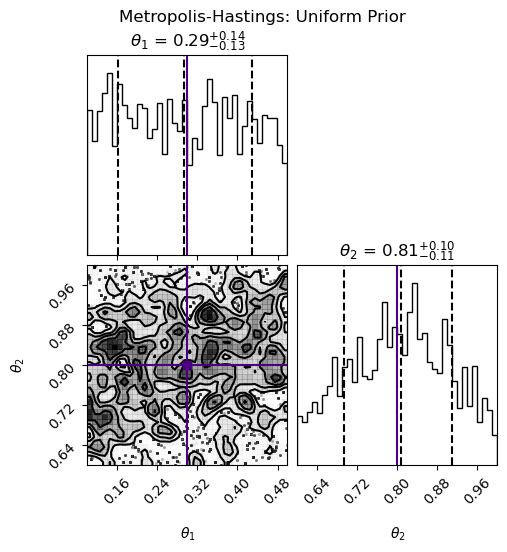

In [10]:
sigma = 1
# BP Defining the step size.
samples = mcmc_mh(n, theta0, sigma, target)
# BP Running the MCMC.

figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 40,
    truth_color = 'indigo',
    )
_ = figure.suptitle('Metropolis-Hastings: Uniform Prior', y = 1.01)

While this appears to be converging the same as the last run, there are clearly many fewer samples, which is echoed by the low acceptance rate. We must also be careful to avoid step sizes that are too small and will not sample all of parameter space efficiently.

Finished 100000 steps with an efficiency of 99.55%


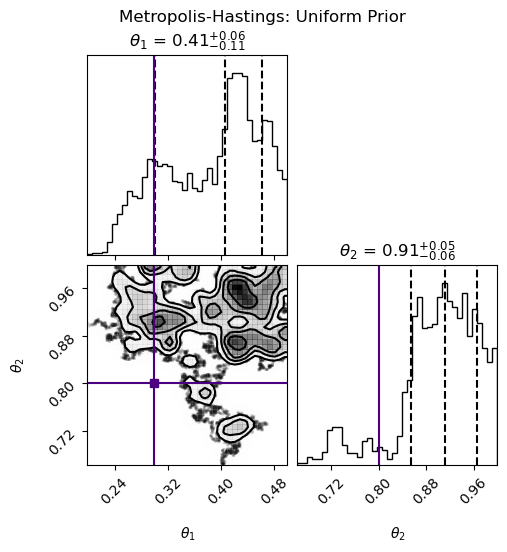

In [11]:
sigma = 0.001
# BP Defining the step size.
samples = mcmc_mh(n, theta0, sigma, target)
# BP Running the MCMC.

figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 40,
    truth_color = 'indigo',
    )
_ = figure.suptitle('Metropolis-Hastings: Uniform Prior', y = 1.01)

While nearly all of the steps were accepted, it is clear not all of parameter space was effectively explored. A delicate balance must be made between the number of steps and the step size. This is further evidenced by the chain, which does not converge.

Text(0.5, 1.0, 'Metropolis-Hastings Chain')

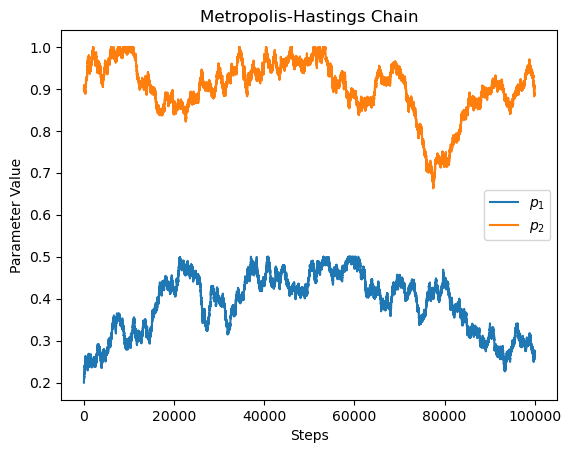

In [12]:
plt.plot(samples[:, 0], label='$p_1$')
plt.plot(samples[:, 1], label='$p_2$')
plt.xlabel('Steps')
plt.ylabel('Parameter Value')
plt.legend(loc = 'best')
plt.title('Metropolis-Hastings Chain')

## Gaussian Prior

Alternatively, we can run the same analysis with more informative Gaussian priors with tight widths.

In [13]:
def gauss_prior(thetas):
    '''
    Prior distribution defining propability of parameters being a given value.
    '''
    if (thetas[0] < 0.1) | (thetas[0] > 0.5):
        return 0
    elif (thetas[1] < 0.6) | (thetas[1] > 1.0):
        return 0
    else:
        #return 1
        return st.multivariate_normal.pdf(thetas, mean = [0.3, 0.8], cov = [[0.001, 0], [0, 0.001]])
    # BP Defining gaussian priors from 0.1-0.5 and 0.6-1.0 centered at 0.3 and 0.8.

We then redefine our target distribution using this updated prior.

In [14]:
def target(thetas):
    '''
    Target distribution as a function of purely parameters. Uses already defined prior, likelihood, data, and covariance.
    '''
    return gauss_prior(thetas) * likelihood(thetas, data, covariance)
# BP Defining target distribution using already specified variables.

We can then rerun the analysis with the new prior function.

Finished 100000 steps with an efficiency of 15.31%


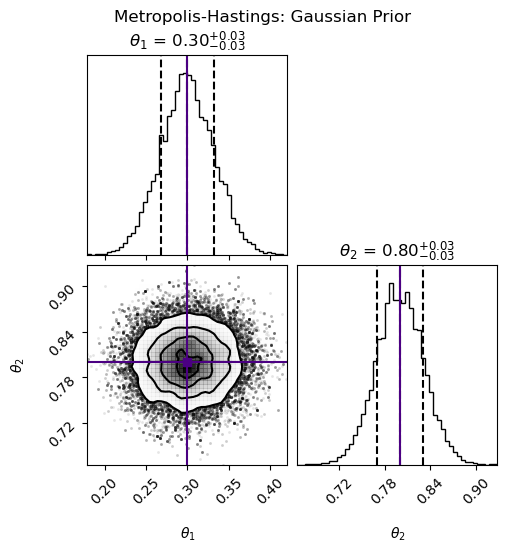

In [15]:
n = 100000
# BP Defining number of steps.
sigma = 0.1
# BP Defining step size.

samples = mcmc_mh(n, theta0, sigma, target)
# BP Running MCMC.
figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 50,
    truth_color = 'indigo'
    )
_ = figure.suptitle('Metropolis-Hastings: Gaussian Prior', y = 1.01)

We now, clearly, have much more constrained results for our parameters. In fact, most of this constraint comes from the priors themselves, rather than from the data.

Perhaps now we assume that our predicted value for both parameters is different than the truth. We once again can define a new prior and likelihood.

In [16]:
def gauss_prior(thetas):
    '''
    Prior distribution defining propability of parameters being a given value.
    '''
    if (thetas[0] < 0.1) | (thetas[0] > 0.5):
        return 0
    elif (thetas[1] < 0.6) | (thetas[1] > 1.0):
        return 0
    else:
        #return 1
        return st.multivariate_normal.pdf(thetas, mean = [0.45, 0.75], cov = [[0.001, 0], [0, 0.001]])
    # BP Defining gaussian priors from 0.1-0.5 and 0.6-1.0 centered at 0.3 and 0.8.

We then redefine our target distribution using this updated prior.

In [17]:
def target(thetas):
    '''
    Target distribution as a function of purely parameters. Uses already defined prior, likelihood, data, and covariance.
    '''
    return gauss_prior(thetas) * likelihood(thetas, data, covariance)
# BP Defining target distribution using already specified variables.

We can then rerun the analysis with the new prior function.

Finished 100000 steps with an efficiency of 13.74%


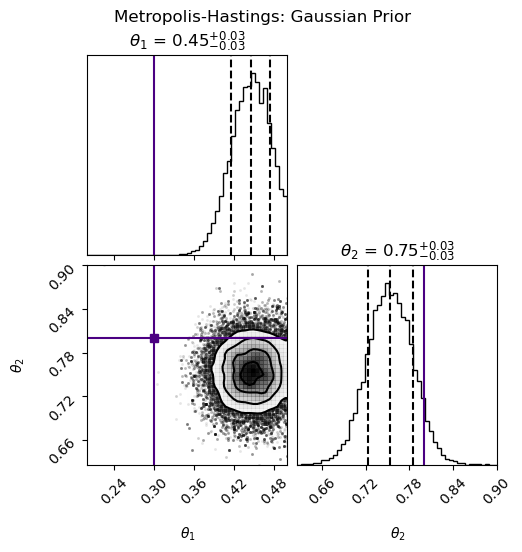

In [18]:
samples = mcmc_mh(n, theta0, sigma, target)

figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 50,
    truth_color = 'indigo'
    )
_ = figure.suptitle('Metropolis-Hastings: Gaussian Prior', y = 1.01)

With such strong priors, the posterior is very strongly influenced.

## Gibbs Sampling

In [ ]:
def prior1

def prior2

In [ ]:
def likelihood1

def likelihood2

In [ ]:
def target1

def target2


In [ ]:
def mcmc_gibbs(n, thetas, targets):
    '''
    Primary loop to calculate posterior (target) distribution for a given prior and likelihood using the Metropolis-Hastings MCMC algorithm.
    '''
    samples = np.empty([n, np.size(thetas)])
    n_accept = 0
    # BP Looping over all iterations
    for i in range(n):
        theta = [target(thetas)]
        
        
        target = prior(thetas) * likelihood(thetas)
        # BP Calculating target distribution for current point.
        
        thetas_prime = thetas + rand.normal(0, sigma, size = 2)
        # BP Calculating new point as small perturbation from current point by sampling a Gaussian with width sigma and mean zero.
        target_prime = prior(thetas_prime) * likelihood(thetas_prime)
        # BP Calculating target distribution for new point.
        
        rho = target_prime / target
        # BP Calculating likelihood ratio of new point to old point.
        
        u = rand.uniform()
        # BP Sampling from random distribution.
        
        # BP Checking if ratio is less than the random uniform sample, which is only true when the ratio is less than 1.
        if u < rho:
            n_accept += 1
            thetas = thetas_prime
            # BP Accepting new point as a point in the chain if it is better than the current point (rho > 1) or if it is randomly selected (rho > u).
        else:
            pass
            # BP Rejecting point if it is not selected (rho < u).
        samples[i] = thetas
        # BP Setting next point in the chain.
        
    print("Finished {} steps with an efficiency of {:.2f}%".format(n, n_accept/n*100))
    
    return samples